# 1. Setup and Data Loading


In [34]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import k_fold_cross_validation

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    classification_report,
    mutual_info_score,
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

import shap

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)

RANDOM_STATE = 42

In [35]:
# %%
try:
    df = pd.read_csv("dataset.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(
        "Error: dataset.csv not found. Please make sure the file is in the"
        " same directory."
    )
    exit()

print("\nDataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nDataset Info:")
df.info()
print("\nMissing Values:\n", df.isnull().sum())
print(
    "\nBasic Statistics (Quantitative Features):\n",
    df.describe().T[["mean", "std", "min", "max"]],
)

print("\nUnique values in binary/categorical features:")
binary_cols = [
    "anaemia",
    "diabetes",
    "high_blood_pressure",
    "sex",
    "smoking",
    "DEATH_EVENT",
]
for col in binary_cols:
    print(f"- {col}: {df[col].unique()}")

Dataset loaded successfully.

Dataset Shape: (299, 13)

First 5 Rows:
     age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0

# 2. Exploratory Data Analysis (EDA)

Reproducing insights similar to Figures 1-14 in the paper.


## 2.1 Categorical Features Analysis (Similar to Fig 1, 2, 3, 4, 6, 7, 14)


Distribution of Categorical Features:


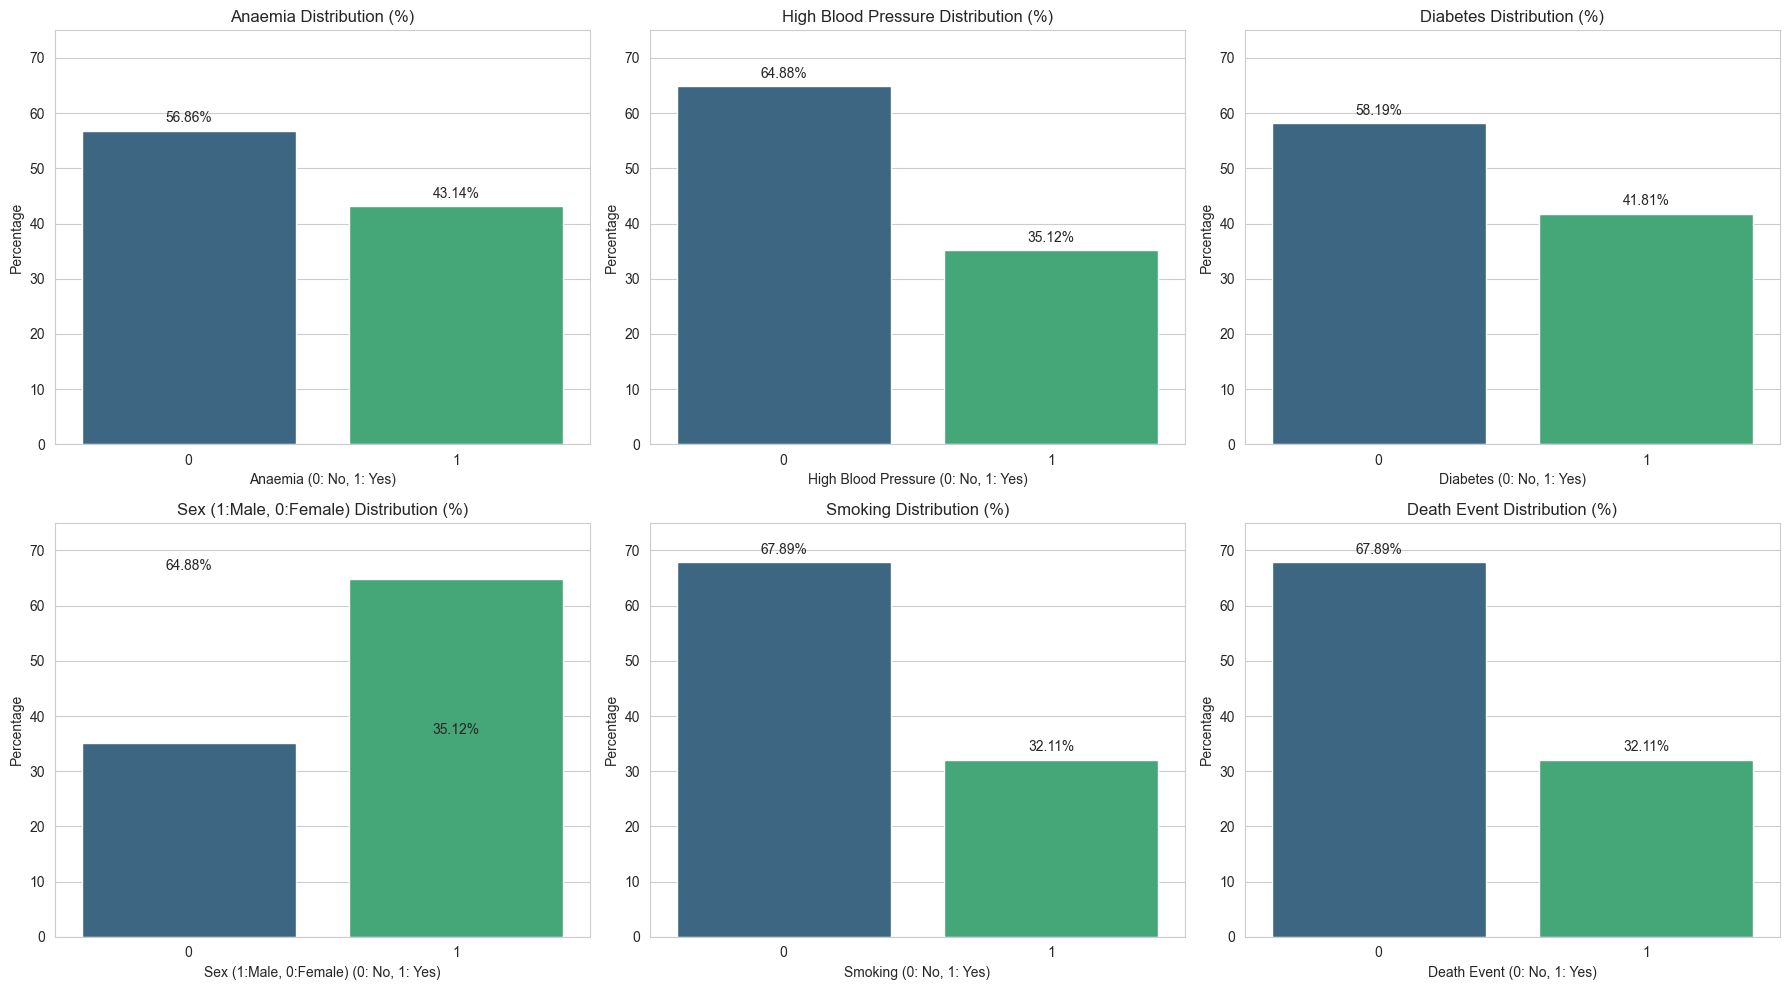

In [36]:
# %%
print("Distribution of Categorical Features:")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

cat_cols = [
    "anaemia",
    "high_blood_pressure",
    "diabetes",
    "sex",
    "smoking",
    "DEATH_EVENT",
]
titles = [
    "Anaemia",
    "High Blood Pressure",
    "Diabetes",
    "Sex (1:Male, 0:Female)",
    "Smoking",
    "Death Event",
]

for i, col in enumerate(cat_cols):
    counts = df[col].value_counts(normalize=True) * 100
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette="viridis")
    axes[i].set_title(f"{titles[i]} Distribution (%)")
    axes[i].set_xlabel(f"{titles[i]} (0: No, 1: Yes)")
    axes[i].set_ylabel("Percentage")
    axes[i].set_ylim(0, 75)
    for index, value in enumerate(counts):
        axes[i].text(index, value + 1, f"{value:.2f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()


Relationship between Categorical Features and DEATH_EVENT:


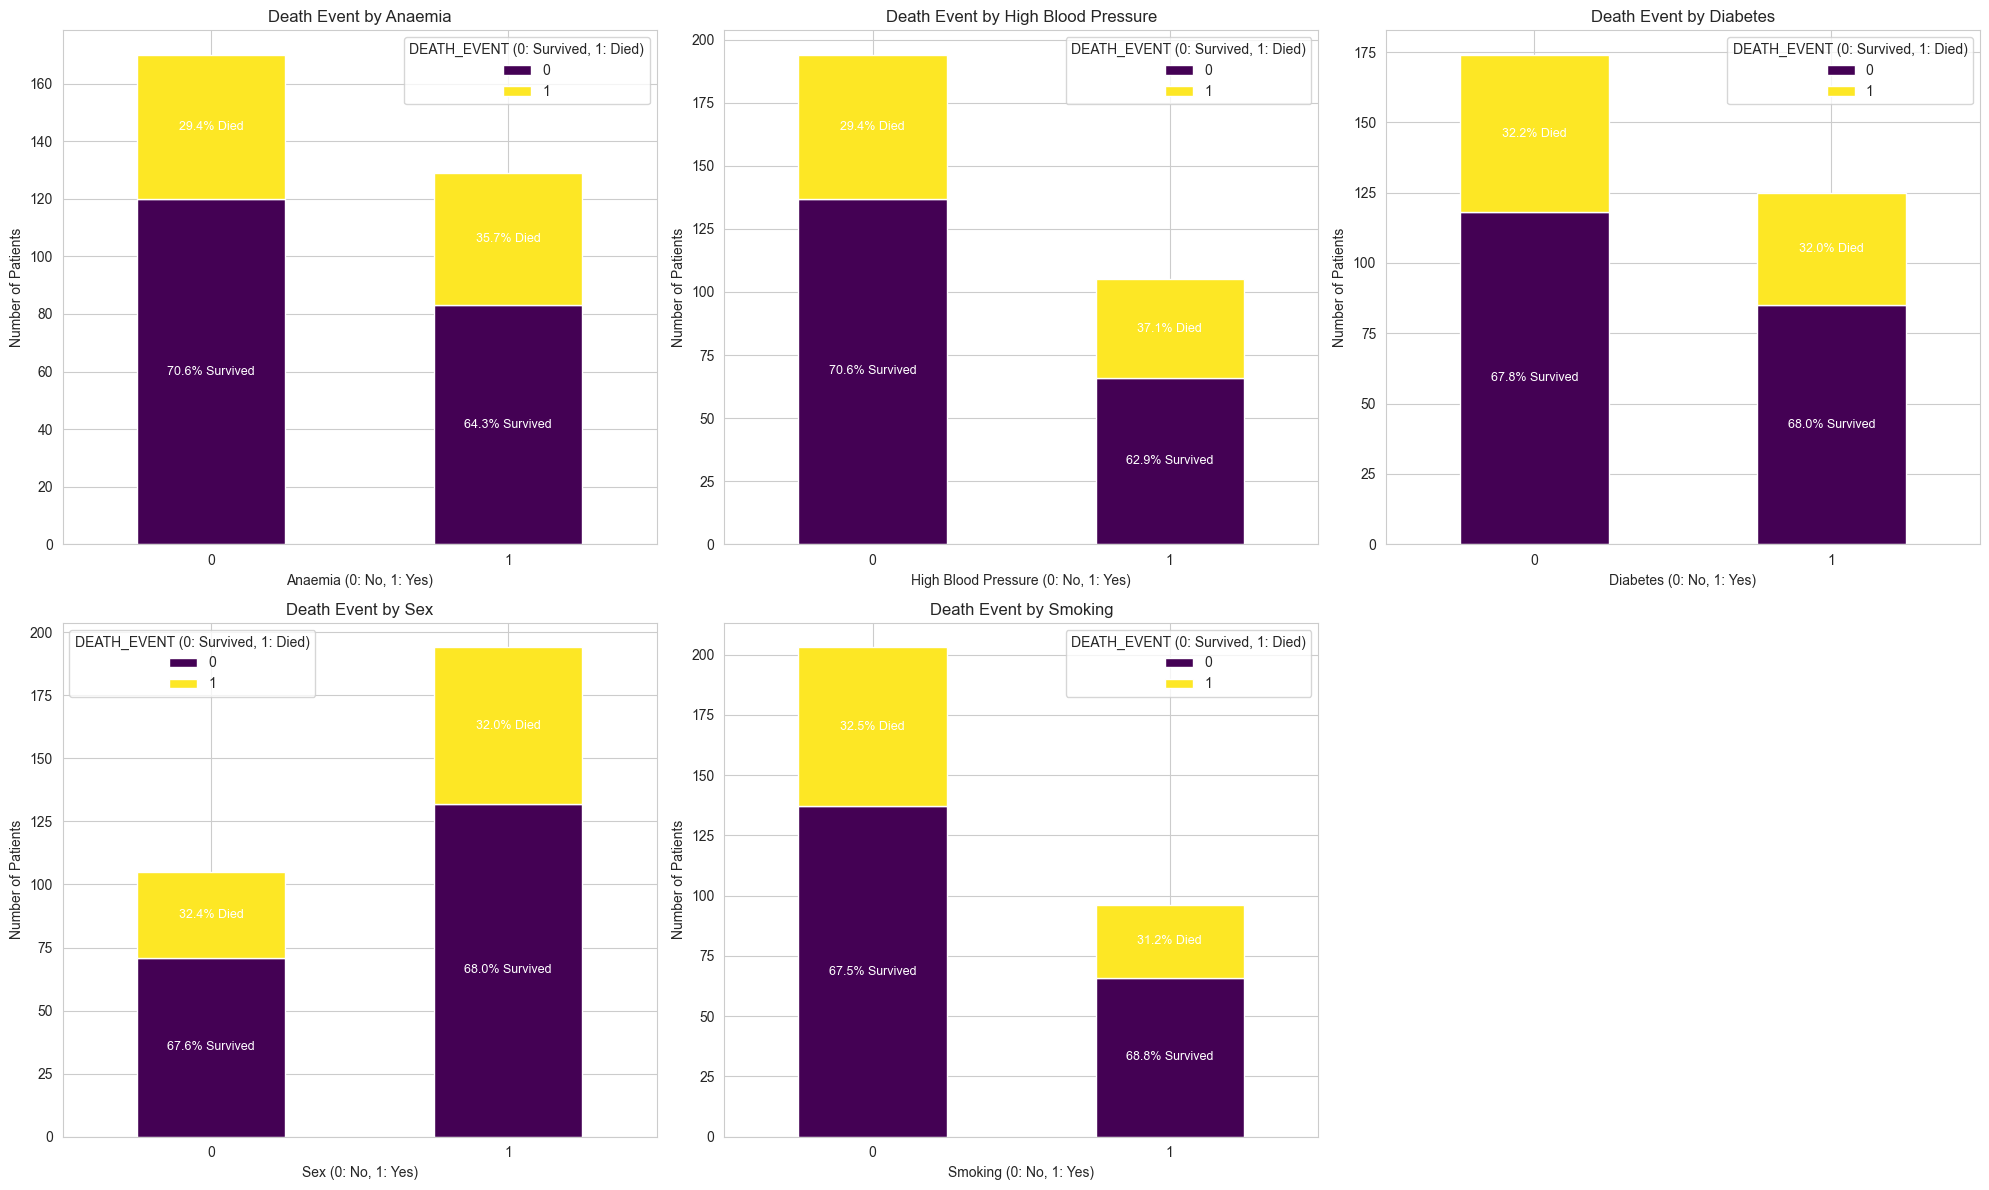

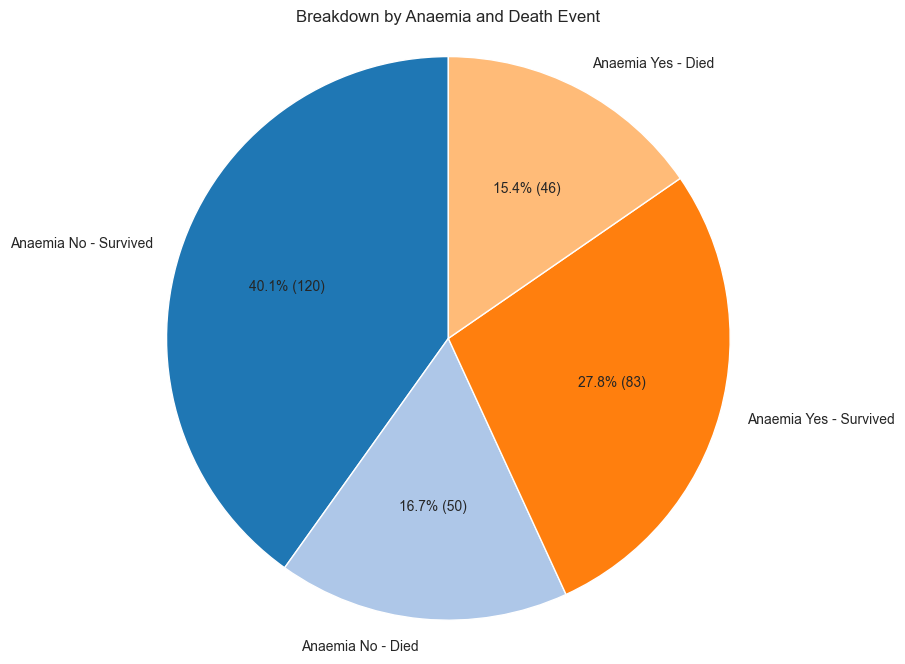

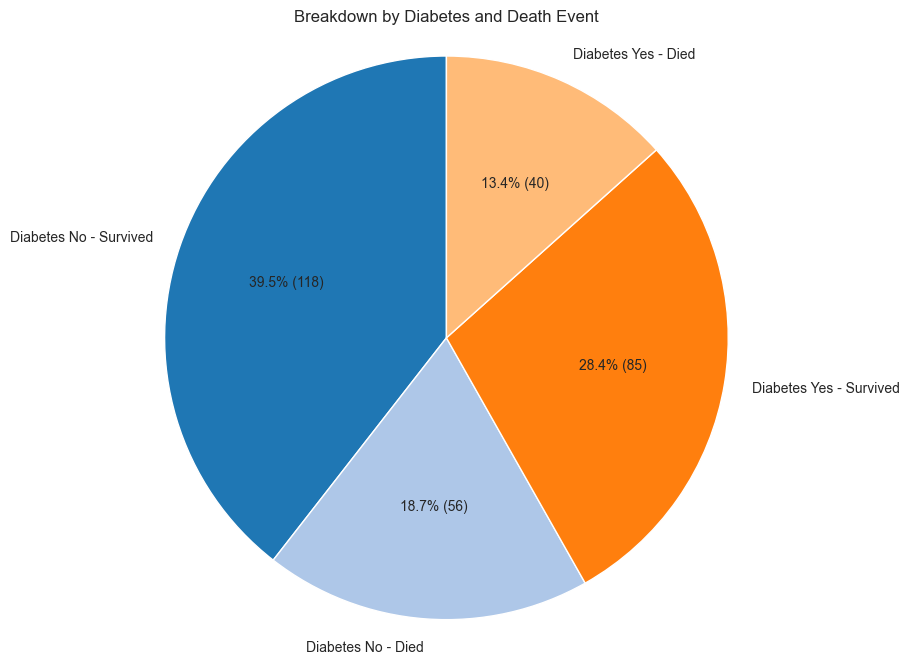

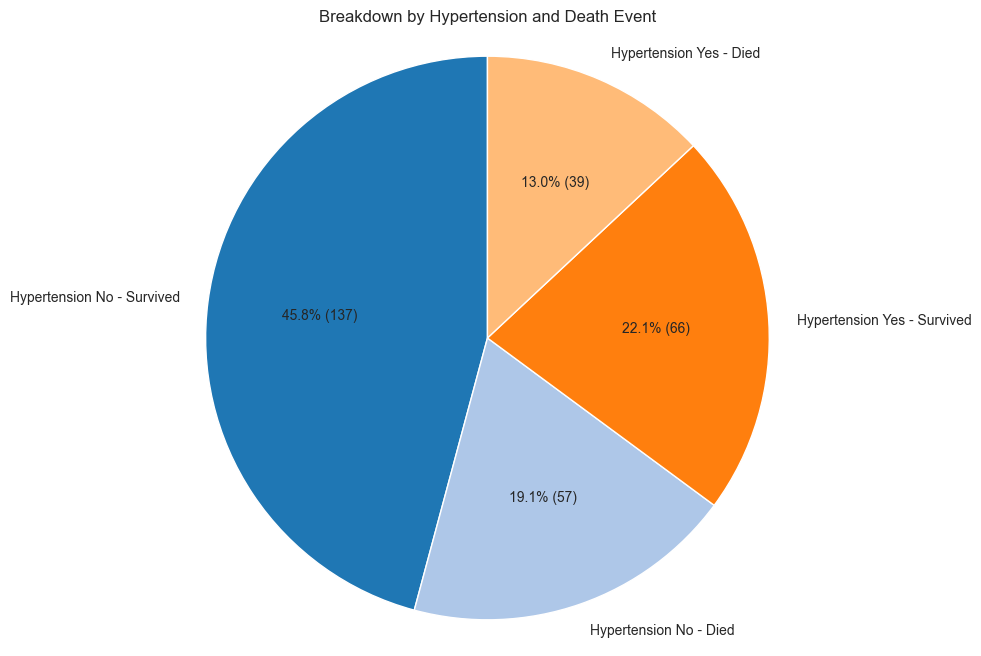

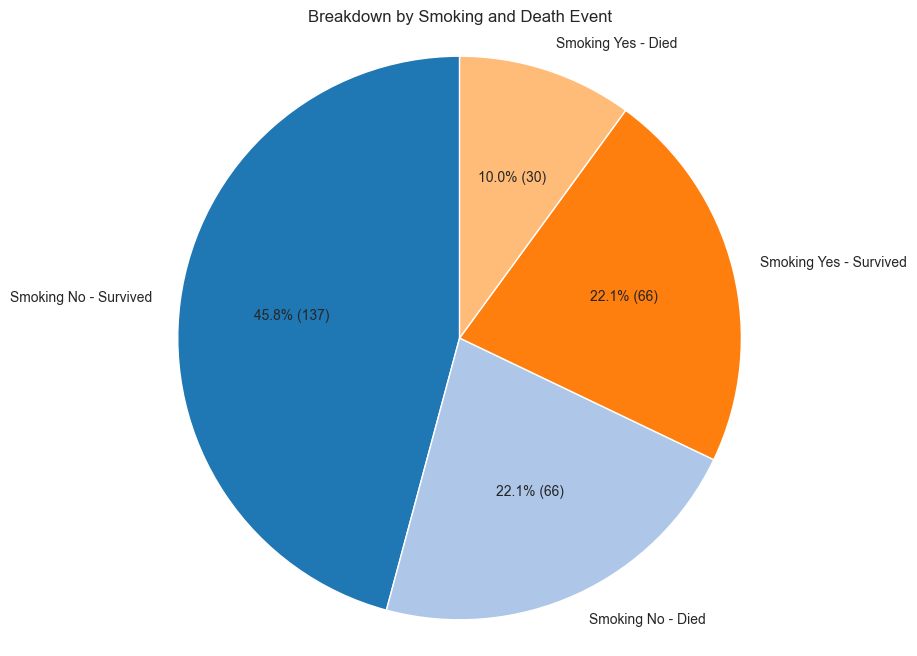

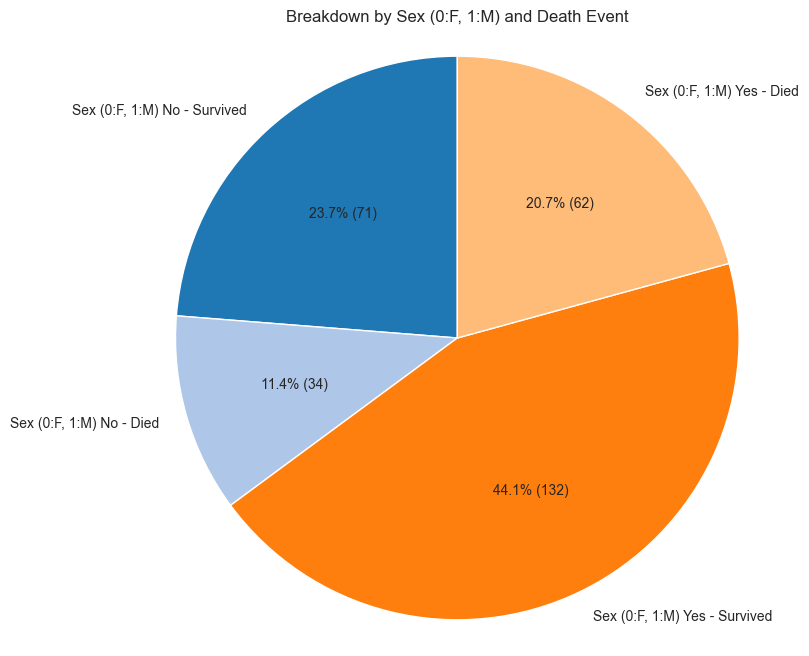

In [37]:
# %%
print("\nRelationship between Categorical Features and DEATH_EVENT:")

fig_rel, axes_rel = plt.subplots(2, 3, figsize=(20, 12))
axes_rel = axes_rel.flatten()
rel_cols = ["anaemia", "high_blood_pressure", "diabetes", "sex", "smoking"]
rel_titles = [
    "Anaemia",
    "High Blood Pressure",
    "Diabetes",
    "Sex",
    "Smoking",
]

for i, col in enumerate(rel_cols):
    ct = pd.crosstab(df[col], df["DEATH_EVENT"], normalize="all") * 100
    ct_abs = pd.crosstab(df[col], df["DEATH_EVENT"])

    ct_abs.plot(kind="bar", stacked=True, ax=axes_rel[i], colormap="viridis")
    axes_rel[i].set_title(f"Death Event by {rel_titles[i]}")
    axes_rel[i].set_xlabel(f"{rel_titles[i]} (0: No, 1: Yes)")
    axes_rel[i].set_ylabel("Number of Patients")
    axes_rel[i].legend(title="DEATH_EVENT (0: Survived, 1: Died)")
    axes_rel[i].tick_params(axis="x", rotation=0)

    total_0 = ct_abs.loc[0].sum()
    total_1 = ct_abs.loc[1].sum()
    if total_0 > 0:
        perc_0_0 = (ct_abs.loc[0, 0] / total_0) * 100
        perc_0_1 = (ct_abs.loc[0, 1] / total_0) * 100
        axes_rel[i].text(
            0,
            ct_abs.loc[0, 0] / 2,
            f"{perc_0_0:.1f}% Survived",
            ha="center",
            va="center",
            color="white",
            fontsize=9,
        )
        axes_rel[i].text(
            0,
            ct_abs.loc[0, 0] + ct_abs.loc[0, 1] / 2,
            f"{perc_0_1:.1f}% Died",
            ha="center",
            va="center",
            color="white",
            fontsize=9,
        )
    if total_1 > 0:
        perc_1_0 = (ct_abs.loc[1, 0] / total_1) * 100
        perc_1_1 = (ct_abs.loc[1, 1] / total_1) * 100
        axes_rel[i].text(
            1,
            ct_abs.loc[1, 0] / 2,
            f"{perc_1_0:.1f}% Survived",
            ha="center",
            va="center",
            color="white",
            fontsize=9,
        )
        axes_rel[i].text(
            1,
            ct_abs.loc[1, 0] + ct_abs.loc[1, 1] / 2,
            f"{perc_1_1:.1f}% Died",
            ha="center",
            va="center",
            color="white",
            fontsize=9,
        )


fig_rel.delaxes(axes_rel[5])
plt.tight_layout()
plt.show()


def plot_pie_breakdown(df, feature_col, title):
    grouped = df.groupby([feature_col, "DEATH_EVENT"]).size().unstack(fill_value=0)
    labels = []
    sizes = []
    colors = []
    color_map = {
        (0, 0): "#1f77b4",
        (0, 1): "#aec7e8",
        (1, 0): "#ff7f0e",
        (1, 1): "#ffbb78",
    }

    total = len(df)
    for feat_val in grouped.index:
        for death_val in grouped.columns:
            count = grouped.loc[feat_val, death_val]
            if count > 0:
                feat_label = "Yes" if feat_val == 1 else "No"
                death_label = "Died" if death_val == 1 else "Survived"
                labels.append(f"{title} {feat_label} - {death_label}")
                sizes.append(count)
                colors.append(color_map[(feat_val, death_val)])

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(
        sizes,
        labels=labels,
        autopct=lambda p: "{:.1f}% ({:.0f})".format(p, p * total / 100),
        startangle=90,
        colors=colors,
    )
    ax.axis("equal")
    plt.title(f"Breakdown by {title} and Death Event")
    plt.show()


plot_pie_breakdown(df, "anaemia", "Anaemia")
plot_pie_breakdown(df, "diabetes", "Diabetes")
plot_pie_breakdown(df, "high_blood_pressure", "Hypertension")
plot_pie_breakdown(df, "smoking", "Smoking")
plot_pie_breakdown(df, "sex", "Sex (0:F, 1:M)")

## 2.2 Quantitative Features Analysis (Similar to Fig 5, 8, 9, 10, 11, 12, 13)


Distribution of Quantitative Features:


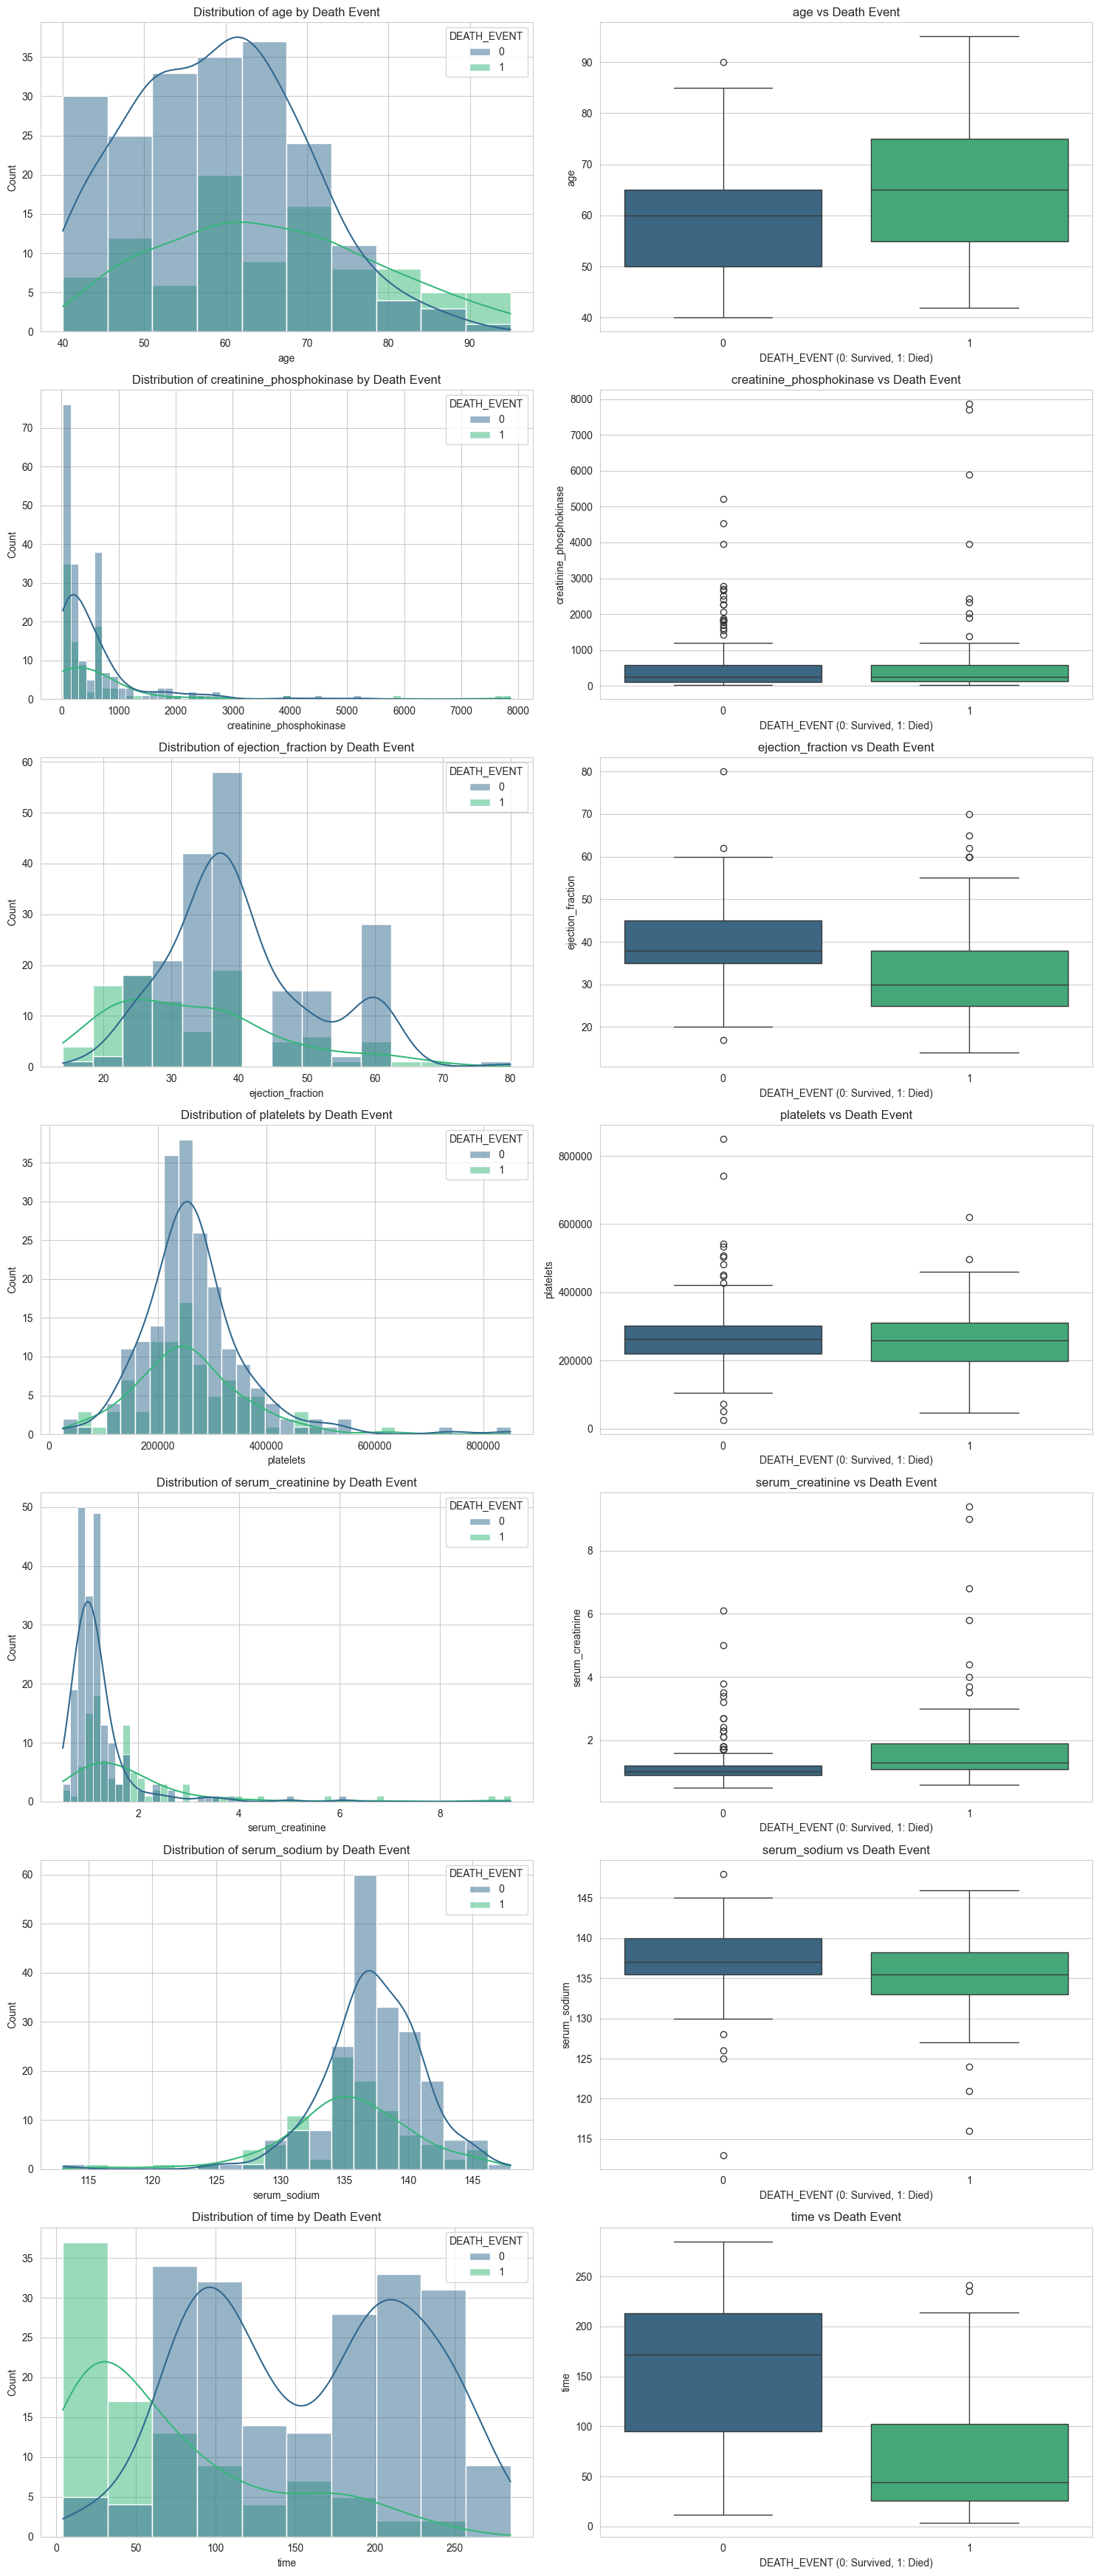

In [38]:
# %%
quant_cols = [
    "age",
    "creatinine_phosphokinase",
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
    "time",
]

print("Distribution of Quantitative Features:")
fig_quant, axes_quant = plt.subplots(
    len(quant_cols), 2, figsize=(15, 5 * len(quant_cols))
)

for i, col in enumerate(quant_cols):
    sns.histplot(
        data=df,
        x=col,
        hue="DEATH_EVENT",
        kde=True,
        ax=axes_quant[i, 0],
        palette="viridis",
    )
    axes_quant[i, 0].set_title(f"Distribution of {col} by Death Event")

    sns.boxplot(
        data=df,
        x="DEATH_EVENT",
        y=col,
        ax=axes_quant[i, 1],
        palette="viridis",
    )
    axes_quant[i, 1].set_title(f"{col} vs Death Event")
    axes_quant[i, 1].set_xlabel("DEATH_EVENT (0: Survived, 1: Died)")

plt.tight_layout()
plt.show()

# 3. Survival Analysis

Reproducing Kaplan-Meier estimates (Fig 15, 16, 17) and Cox Proportional Hazards

model results (Fig 18, 19).


In [39]:
# %%
T = df["time"]
E = df["DEATH_EVENT"]

## 3.1 Kaplan-Meier Estimates


### 3.1.1 Categorical Features (Similar to Fig 15)


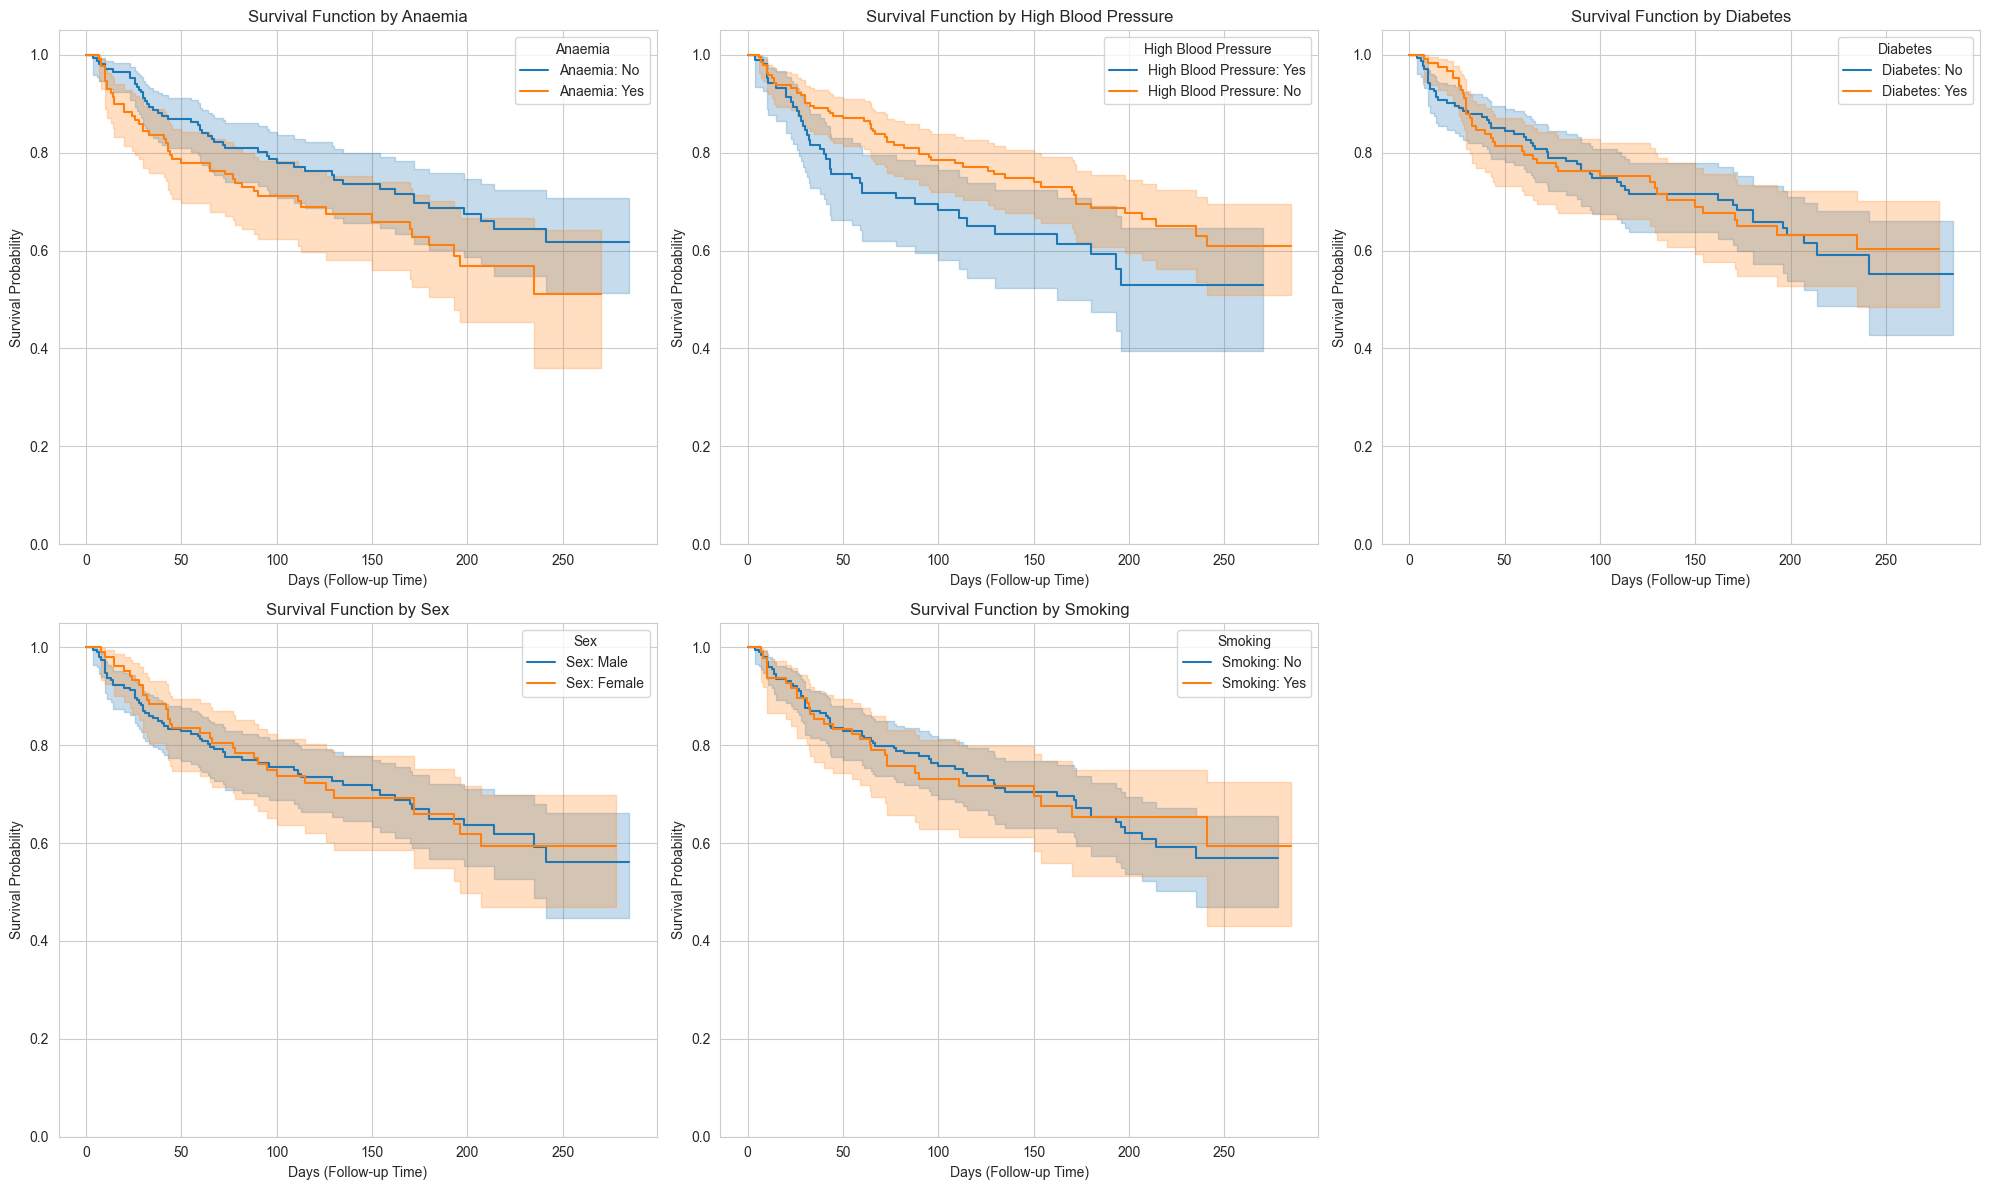

In [40]:
# %%
kmf = KaplanMeierFitter()

fig_km_cat, axes_km_cat = plt.subplots(2, 3, figsize=(20, 12))
axes_km_cat = axes_km_cat.flatten()

for i, col in enumerate(rel_cols):
    ax = axes_km_cat[i]
    for value in df[col].unique():
        mask = df[col] == value
        label_suffix = "Yes" if value == 1 else "No"
        if col == "sex":
            label_suffix = "Male" if value == 1 else "Female"
        kmf.fit(
            T[mask],
            event_observed=E[mask],
            label=f"{rel_titles[i]}: {label_suffix}",
        )
        kmf.plot_survival_function(ax=ax)

    ax.set_title(f"Survival Function by {rel_titles[i]}")
    ax.set_xlabel("Days (Follow-up Time)")
    ax.set_ylabel("Survival Probability")
    ax.legend(title=rel_titles[i])
    ax.set_ylim(0, 1.05)

fig_km_cat.delaxes(axes_km_cat[5])
plt.tight_layout()
plt.show()

### 3.1.2 Continuous Features (Similar to Fig 16, 17)

We need to bin continuous features to plot KM curves like the paper.


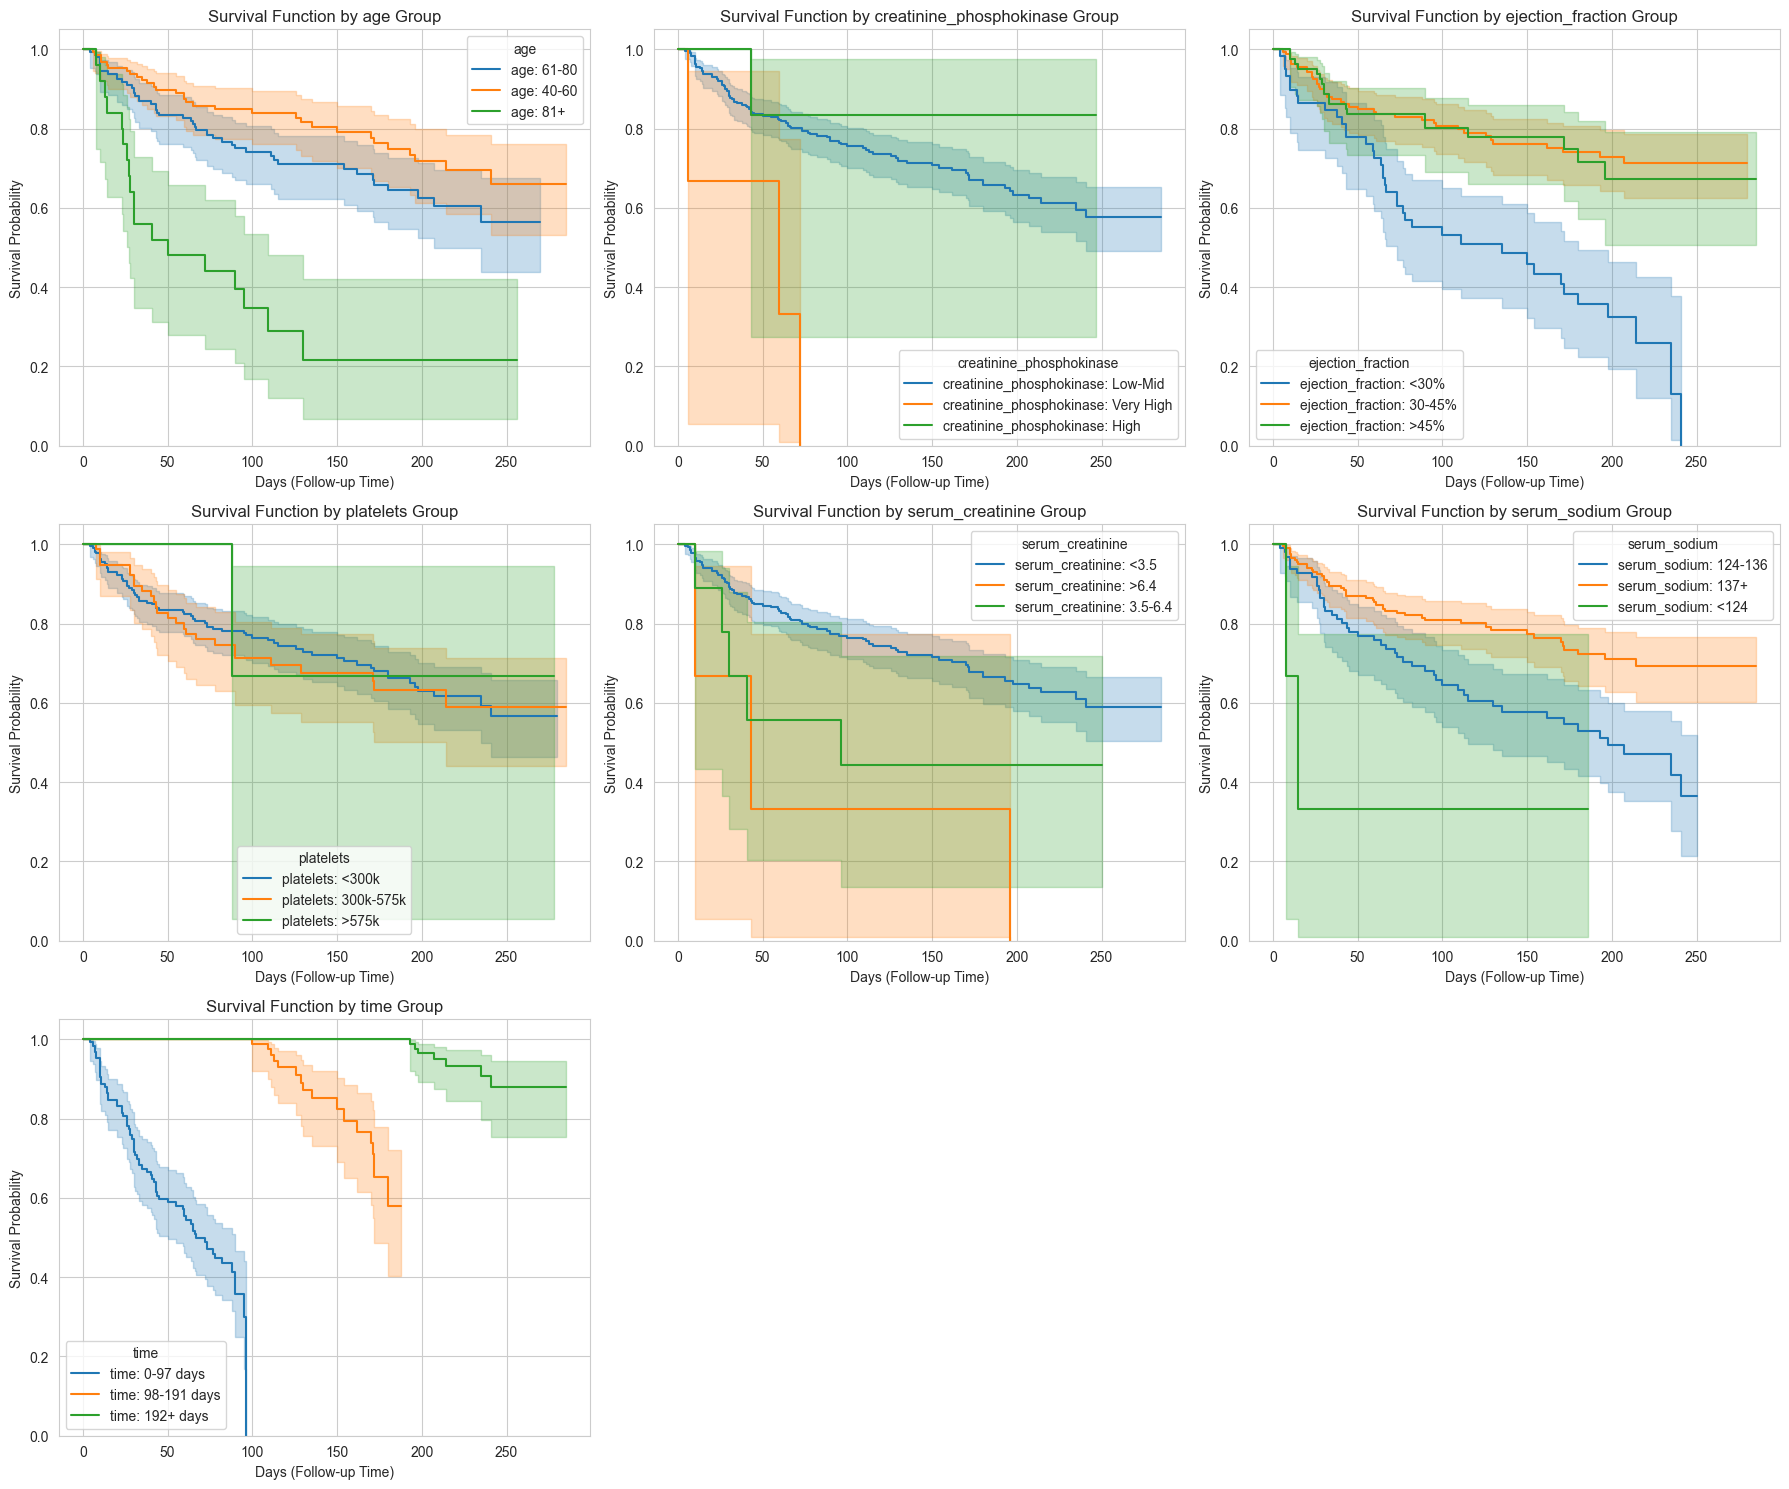

In [41]:
# %%
bin_defs = {
    "age": {"bins": [39, 60, 80, 101], "labels": ["40-60", "61-80", "81+"]},
    "creatinine_phosphokinase": {
        "bins": [0, 2636, 5249, 8000],
        "labels": ["Low-Mid", "High", "Very High"],
    },
    "ejection_fraction": {
        "bins": [0, 30, 45, 100],
        "labels": ["<30%", "30-45%", ">45%"],
    },
    "platelets": {
        "bins": [0, 300000, 575000, 900000],
        "labels": ["<300k", "300k-575k", ">575k"],
    },
    "serum_creatinine": {
        "bins": [0, 3.47, 6.43, 10],
        "labels": ["<3.5", "3.5-6.4", ">6.4"],
    },
    "serum_sodium": {
        "bins": [110, 124, 136, 150],
        "labels": ["<124", "124-136", "137+"],
    },
    "time": {
        "bins": [0, 97, 191, 300],
        "labels": ["0-97 days", "98-191 days", "192+ days"],
    },
}

df_binned = df.copy()
for col, definition in bin_defs.items():
    bins = definition["bins"]
    if df[col].min() < bins[0]:
        bins[0] = df[col].min() - 1
    if df[col].max() > bins[-1]:
        bins[-1] = df[col].max() + 1

    df_binned[f"{col}_binned"] = pd.cut(
        df_binned[col], bins=bins, labels=definition["labels"], right=False
    )

n_quant = len(quant_cols)
n_cols_km = 3
n_rows_km = (n_quant + n_cols_km - 1) // n_cols_km
fig_km_cont, axes_km_cont = plt.subplots(
    n_rows_km, n_cols_km, figsize=(18, 5 * n_rows_km)
)
axes_km_cont = axes_km_cont.flatten()

for i, col in enumerate(quant_cols):
    ax = axes_km_cont[i]
    binned_col = f"{col}_binned"
    if binned_col in df_binned.columns:
        for group in df_binned[binned_col].unique():
            if pd.isna(group):
                continue
            mask = df_binned[binned_col] == group
            kmf.fit(T[mask], event_observed=E[mask], label=f"{col}: {group}")
            kmf.plot_survival_function(ax=ax)
        ax.set_title(f"Survival Function by {col} Group")
        ax.set_xlabel("Days (Follow-up Time)")
        ax.set_ylabel("Survival Probability")
        ax.legend(title=col)
        ax.set_ylim(0, 1.05)
    else:
        ax.set_visible(False)

for j in range(i + 1, len(axes_km_cont)):
    axes_km_cont[j].set_visible(False)

plt.tight_layout()
plt.show()

## 3.2 Cox Proportional Hazards Model


Cox Proportional Hazards Model Summary:


<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -478.48
         time fit was run = 2025-04-22 05:24:34 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
age                       0.03      1.03      0.01            0.02            0.05                1.02                1.05
anaemia                   0.32      1.37      0.18           -0.04            0.68                0.96                1.97
creatinine_phosphokinase  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
diabetes                  0.05      1.05      0.19           -0.32            0.42                0.73                1.52
ejection_fraction        -0.03      0.97      0.01           -0.05           -0.02                0.95                0.98
high_blood_pressure       0.37      1.44      0.19           -0.00            0.74                1.00                2.09
platelets                -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
serum_creatinine          0.28      1.32      0.07            0.15            0.40                1.16                1.50
serum_sodium             -0.04      0.96      0.02           -0.08           -0.00                0.92                1.00
sex                      -0.09      0.91      0.20           -0.49            0.31                0.61                1.36
smoking                   0.05      1.06      0.21           -0.35            0.46                0.71                1.58

                          cmp to     z      p  -log2(p)
covariate                                              
age                         0.00  4.24 <0.005     15.42
anaemia                     0.00  1.72   0.09      3.54
creatinine_phosphokinase    0.00  1.56   0.12      3.08
diabetes                    0.00  0.27   0.78      0.35
ejection_fraction           0.00 -3.95 <0.005     13.66
high_blood_pressure         0.00  1.95   0.05      4.30
platelets                   0.00 -0.20   0.84      0.25
serum_creatinine            0.00  4.17 <0.005     15.03
serum_sodium                0.00 -1.97   0.05      4.35
sex                         0.00 -0.45   0.66      0.61
smoking                     0.00  0.26   0.79      0.34
---
Concordance = 0.74
Partial AIC = 978.95
log-likelihood ratio test = 61.46 on 11 df
-log2(p) of ll-ratio test = 27.58


Checking Proportional Hazards Assumption:

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


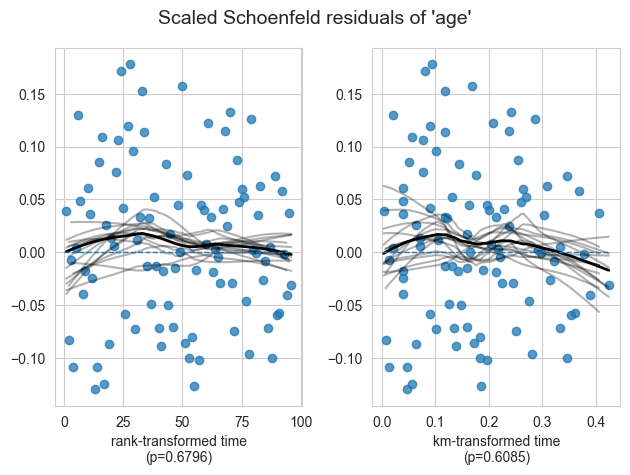

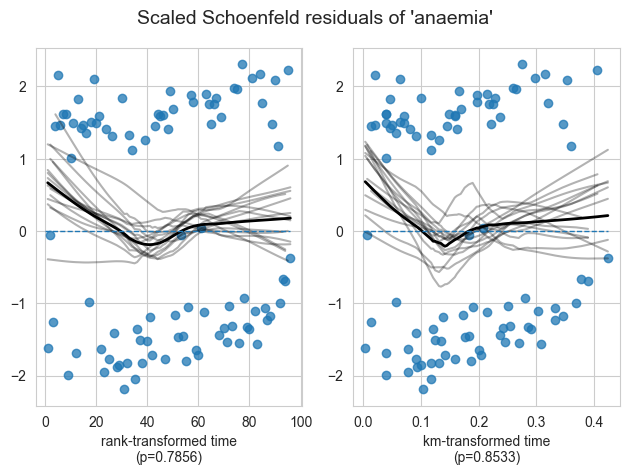

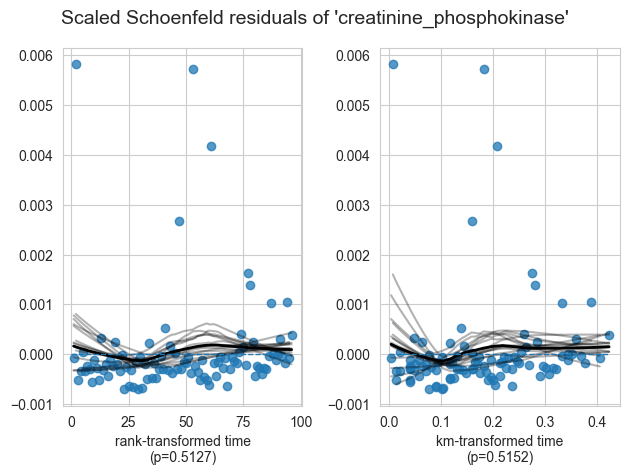

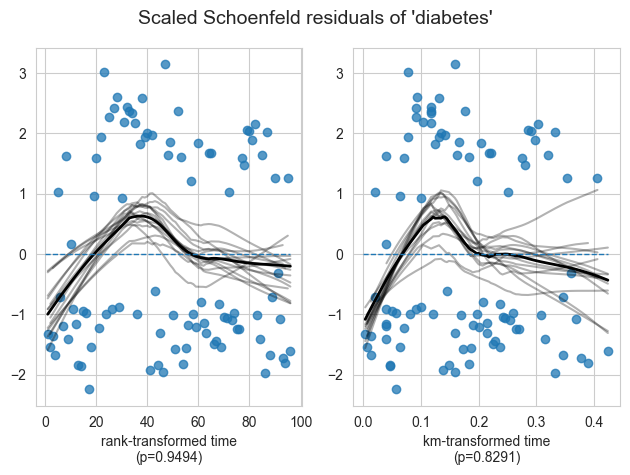

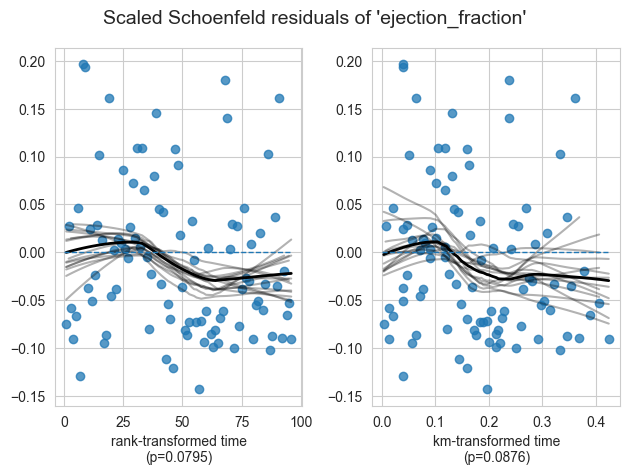

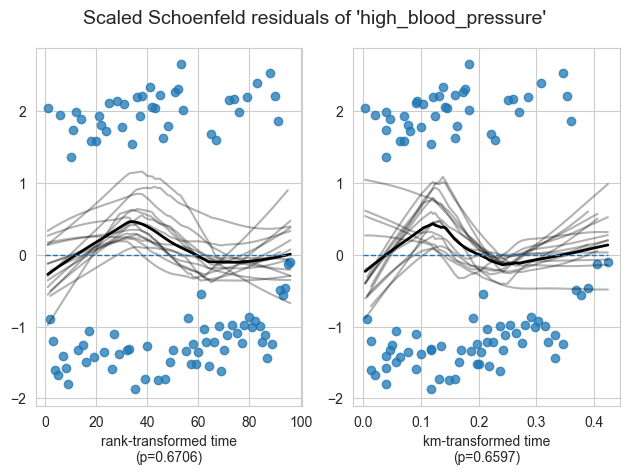

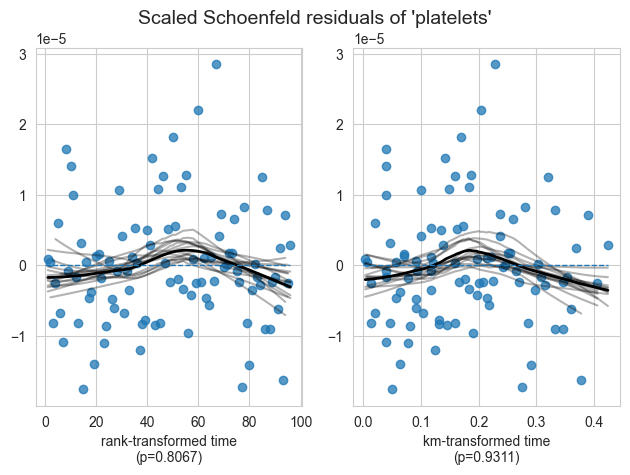

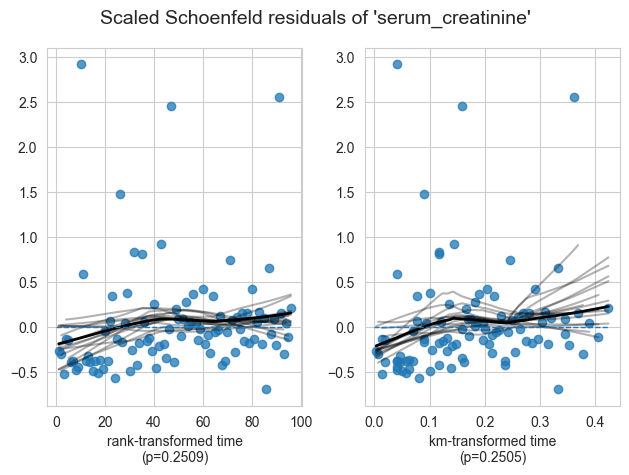

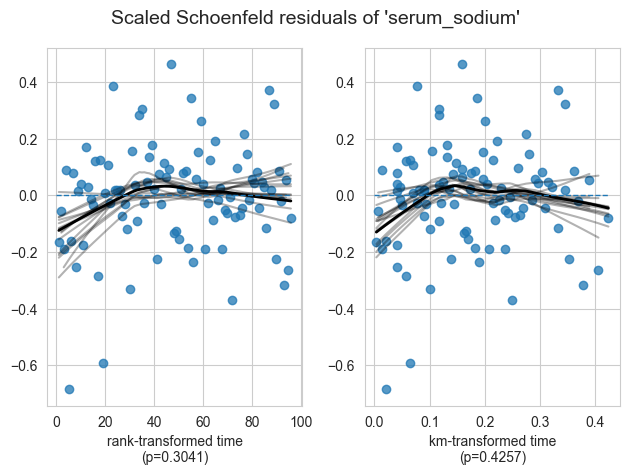

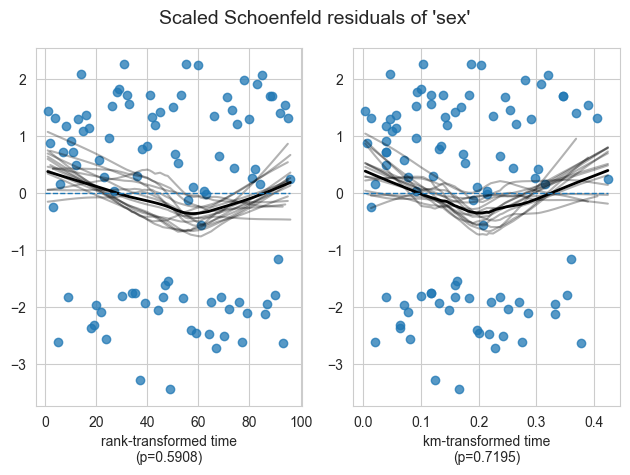

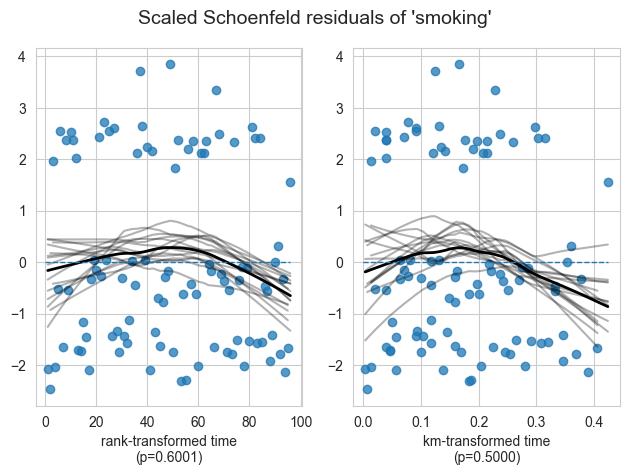

In [42]:
# %%
df_cox = df.copy()

cox_features = [
    "age",
    "anaemia",
    "creatinine_phosphokinase",
    "diabetes",
    "ejection_fraction",
    "high_blood_pressure",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
    "sex",
    "smoking",
]
df_cox_input = df_cox[cox_features + ["time", "DEATH_EVENT"]]

cph = CoxPHFitter(penalizer=0.1)
try:
    cph.fit(df_cox_input, duration_col="time", event_col="DEATH_EVENT")
    print("Cox Proportional Hazards Model Summary:")
    cph.print_summary()

    print("\nChecking Proportional Hazards Assumption:")
    try:
        cph.check_assumptions(df_cox_input, show_plots=True)
        plt.show()
    except Exception as e:
        print(f"Could not perform assumption check: {e}")

except Exception as e:
    print(f"Error fitting Cox model: {e}")
    cph = None

### 3.2.1 Partial Effects Plots (Similar to Fig 18)



Plotting Partial Effects of Significant Covariates:


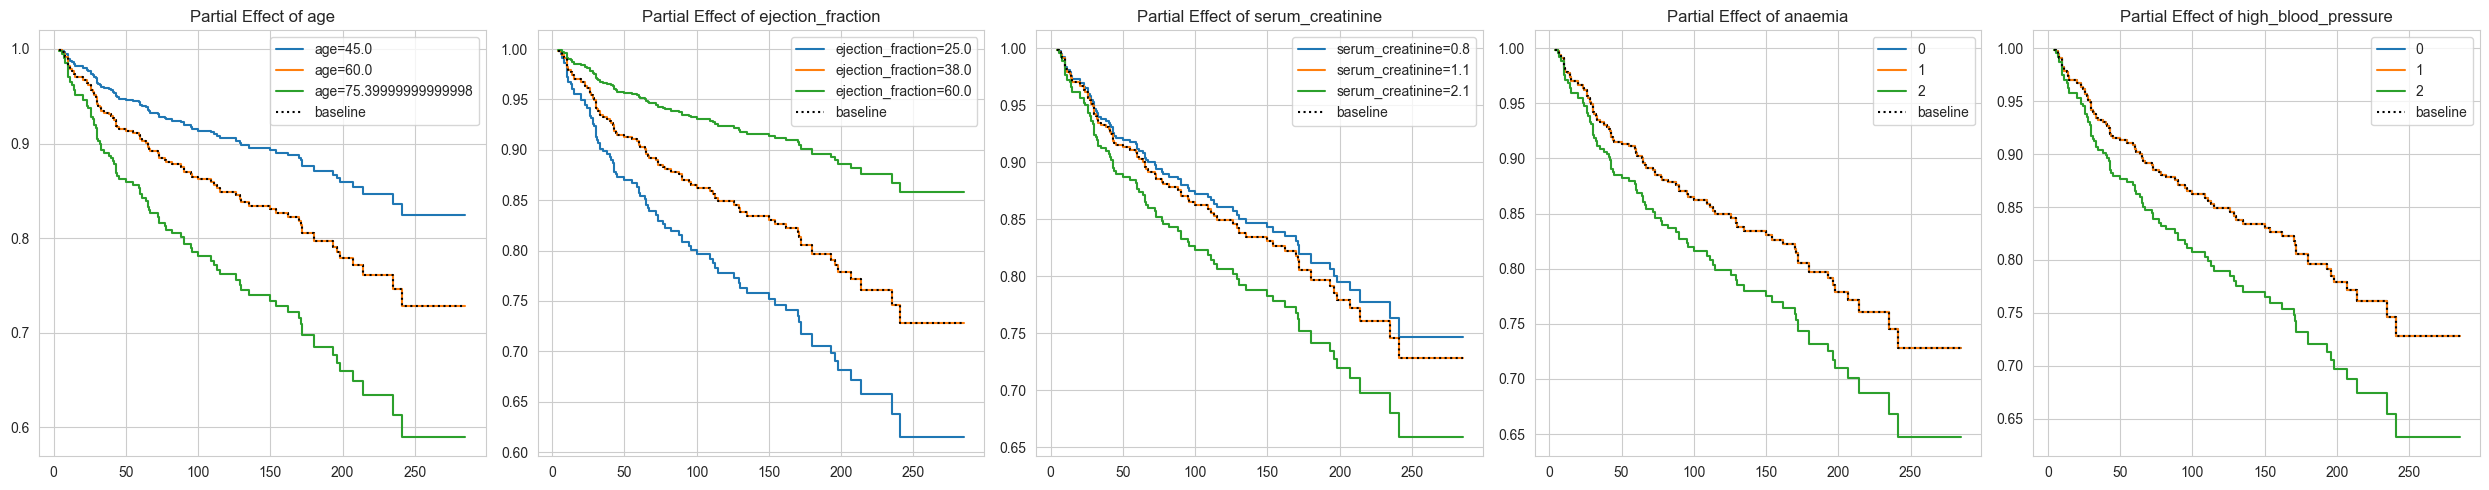

In [43]:
# %%
if cph:
    print("\nPlotting Partial Effects of Significant Covariates:")
    significant_covariates = [
        "age",
        "ejection_fraction",
        "serum_creatinine",
        "anaemia",
        "high_blood_pressure",
    ]
    valid_covariates = [
        cov for cov in significant_covariates if cov in cph.summary.index
    ]

    if valid_covariates:
        fig_partial, axes_partial = plt.subplots(
            1, len(valid_covariates), figsize=(5 * len(valid_covariates), 5)
        )
        if len(valid_covariates) == 1:
            axes_partial = [axes_partial]

        for i, cov in enumerate(valid_covariates):
            try:
                cph.plot_partial_effects_on_outcome(
                    covariates=cov,
                    values=np.percentile(df_cox[cov], [10, 50, 90]),
                    ax=axes_partial[i],
                )
                axes_partial[i].set_title(f"Partial Effect of {cov}")
            except Exception as e:
                print(f"Could not plot partial effect for {cov}: {e}")
                axes_partial[i].set_visible(False)

        plt.tight_layout()
        plt.show()
    else:
        print("No valid significant covariates found to plot partial effects.")
else:
    print("Cox model not fitted successfully, skipping partial effects plots.")

### 3.2.2 Individual Survival Prediction (Similar to Fig 19)



Predicting Survival Functions for Example Patients from Test Set:


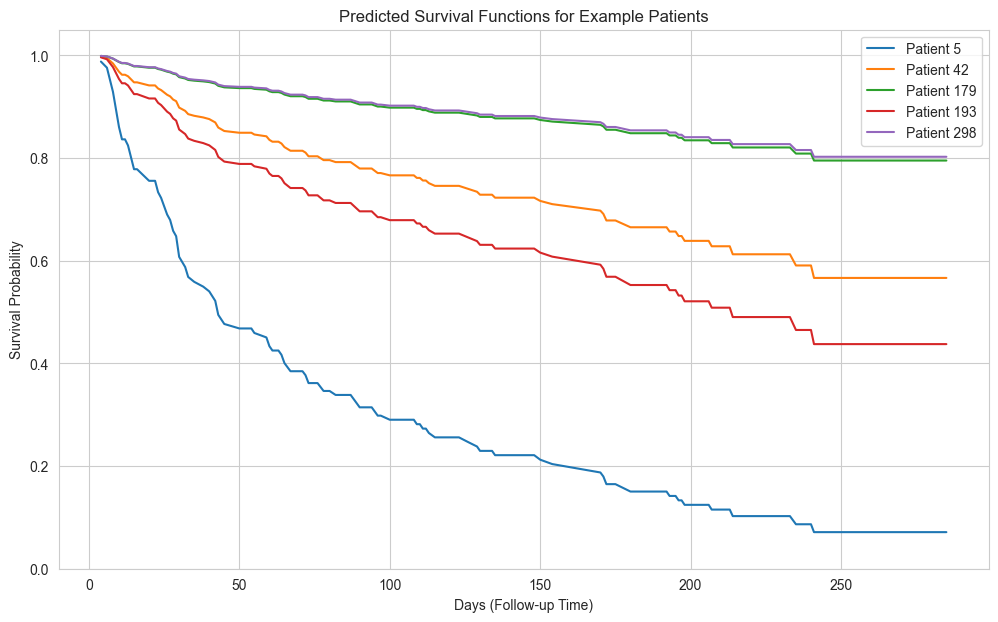

In [44]:
# %%
if cph:
    print("\nPredicting Survival Functions for Example Patients from Test Set:")
    example_indices = [5, 42, 179, 193, 298]
    example_indices = [idx for idx in example_indices if idx < len(df_cox_input)]
    X_examples = df_cox_input.iloc[example_indices][cox_features]

    if not X_examples.empty:
        try:
            survival_functions = cph.predict_survival_function(X_examples)

            plt.figure(figsize=(12, 7))
            for i, idx in enumerate(example_indices):
                plt.plot(
                    survival_functions.index,
                    survival_functions.iloc[:, i],
                    label=f"Patient {idx}",
                )

            plt.title("Predicted Survival Functions for Example Patients")
            plt.xlabel("Days (Follow-up Time)")
            plt.ylabel("Survival Probability")
            plt.legend()
            plt.grid(True)
            plt.ylim(0, 1.05)
            plt.show()
        except Exception as e:
            print(f"Could not predict/plot individual survival functions: {e}")
    else:
        print("No valid example indices found.")
else:
    print("Cox model not fitted successfully, skipping individual predictions.")

# 4. Survival Prediction (Machine Learning Classification)

Reproducing the classification experiments (Table 2).

Features used: Age, Ejection Fraction, Serum Creatinine (as per paper section

C).

Target: DEATH_EVENT.

Methodology: 85/15 split, SMOTE on training data, RandomizedSearchCV for tuning,

evaluation metrics.


In [45]:
# %%
features_ml = ["age", "ejection_fraction", "serum_creatinine"]
X = df[features_ml]
y = df["DEATH_EVENT"]

print(f"\nSelected features for ML: {features_ml}")
print("Target variable: DEATH_EVENT")


Selected features for ML: ['age', 'ejection_fraction', 'serum_creatinine']
Target variable: DEATH_EVENT


In [46]:
# %%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")
print("Train target distribution:\n", y_train.value_counts(normalize=True) * 100)
print("Test target distribution:\n", y_test.value_counts(normalize=True) * 100)


Train set shape: X=(254, 3), y=(254,)
Test set shape: X=(45, 3), y=(45,)
Train target distribution:
 DEATH_EVENT
0    67.716535
1    32.283465
Name: proportion, dtype: float64
Test target distribution:
 DEATH_EVENT
0    68.888889
1    31.111111
Name: proportion, dtype: float64


In [47]:
# %%
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nTrain set shape after SMOTE:", X_train_smote.shape)
print(
    "Train target distribution after SMOTE:\n",
    y_train_smote.value_counts(normalize=True) * 100,
)


Train set shape after SMOTE: (344, 3)
Train target distribution after SMOTE:
 DEATH_EVENT
0    50.0
1    50.0
Name: proportion, dtype: float64


In [48]:
# %%
models = {
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        use_label_encoder=False,
    ),
    "LightGBM": LGBMClassifier(random_state=RANDOM_STATE),
}

param_grids = {
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "gamma": [1, 0.1, 0.01, 0.001],
        "kernel": ["rbf", "linear"],
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 5, 10, 15, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 3, 5],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 3, 5],
        "bootstrap": [True, False],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2, 0.3],
        "max_depth": [3, 5, 7, 10],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [20, 31, 40],
        "max_depth": [-1, 5, 10, 15],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
    },
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

results = {}
best_estimators = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("\nStarting Model Training and Tuning...\n")

for name, model in models.items():
    print(f"--- Training {name} ---")
    param_grid = param_grids[name]

    X_train_fit = X_train_scaled if name == "SVM" else X_train_smote
    X_test_eval = X_test_scaled if name == "SVM" else X_test

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=30,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0,
    )

    try:
        search.fit(X_train_fit, y_train_smote)
        best_model = search.best_estimator_
        best_estimators[name] = best_model
        print(f"Best Params: {search.best_params_}")

        y_pred = best_model.predict(X_test_eval)
        y_proba = (
            best_model.predict_proba(X_test_eval)[:, 1]
            if hasattr(best_model, "predict_proba")
            else None
        )

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        auc_roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        precision_curve, recall_curve, _ = (
            precision_recall_curve(y_test, y_proba)
            if y_proba is not None
            else (None, None, None)
        )
        auc_pr = (
            auc(recall_curve, precision_curve)
            if precision_curve is not None
            else np.nan
        )

        results[name] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "MCC": mcc,
            "AUC ROC": auc_roc,
            "AUC PR": auc_pr,
            "Confusion Matrix": cm,
        }

        print(f"Test F1 Score: {f1:.4f}")
        print(f"Test AUC ROC: {auc_roc:.4f}")
        print(classification_report(y_test, y_pred))
        print(f"Confusion Matrix:\n{cm}\n")

    except Exception as e:
        print(f"Error training/evaluating {name}: {e}")
        results[name] = None

print("\n--- Model Evaluation Summary ---")
results_df = pd.DataFrame(results).T
results_summary = results_df[
    ["F1 Score", "Accuracy", "Precision", "Recall", "MCC", "AUC ROC", "AUC PR"]
].copy()
results_summary["Confusion Matrix"] = results_df["Confusion Matrix"]

for col in results_summary.columns[:-1]:
    results_summary[col] = results_summary[col].map(
        lambda x: "{:.4f}".format(x) if pd.notna(x) else "N/A"
    )

print(results_summary)


Starting Model Training and Tuning...

--- Training SVM ---
Best Params: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
Test F1 Score: 0.6250
Test AUC ROC: 0.7788
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        31
           1       0.56      0.71      0.62        14

    accuracy                           0.73        45
   macro avg       0.70      0.73      0.71        45
weighted avg       0.76      0.73      0.74        45

Confusion Matrix:
[[23  8]
 [ 4 10]]

--- Training Decision Tree ---
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}
Test F1 Score: 0.5161
Test AUC ROC: 0.6809
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        31
           1       0.47      0.57      0.52        14

    accuracy                           0.67        45
   macro avg       0.63      0.64      0.63        45
weighted avg       0.69      0

# 5. Feature Importance and Explainability


## 5.1 Mutual Information (Similar to Fig 20)



Calculating Mutual Information with DEATH_EVENT:


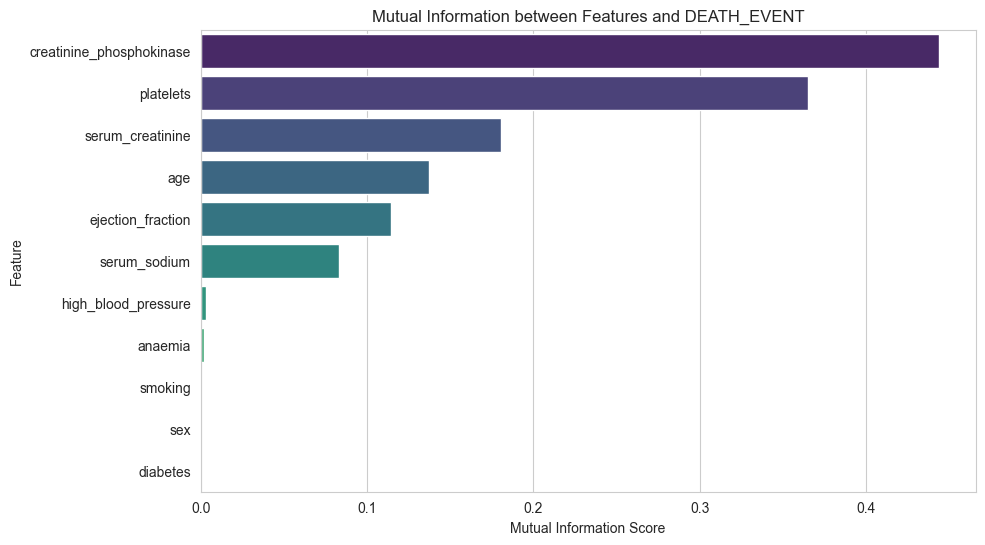


Top Features by Mutual Information:
                           Mutual Information
creatinine_phosphokinase            0.443626
platelets                           0.365035
serum_creatinine                    0.180256
age                                 0.137524
ejection_fraction                   0.114313
serum_sodium                        0.083258
high_blood_pressure                 0.003115
anaemia                             0.002188
smoking                             0.000080
sex                                 0.000009
diabetes                            0.000002


In [49]:
# %%
print("\nCalculating Mutual Information with DEATH_EVENT:")
mi_scores = {}
for col in df.columns:
    if col not in ["time", "DEATH_EVENT"]:
        try:
            mi = mutual_info_score(df[col], df["DEATH_EVENT"])
            mi_scores[col] = mi
        except Exception as e:
            print(f"Could not calculate MI for {col}: {e}")


mi_df = pd.DataFrame.from_dict(
    mi_scores, orient="index", columns=["Mutual Information"]
)
mi_df = mi_df.sort_values("Mutual Information", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi_df["Mutual Information"], y=mi_df.index, palette="viridis")
plt.title("Mutual Information between Features and DEATH_EVENT")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.show()

print("\nTop Features by Mutual Information:\n", mi_df)

## 5.2 SHAP Values for Best Model (e.g., LightGBM - Similar to Fig 21)



Calculating SHAP values for LightGBM model...
Plotting SHAP Summary Plot (Feature Importance):


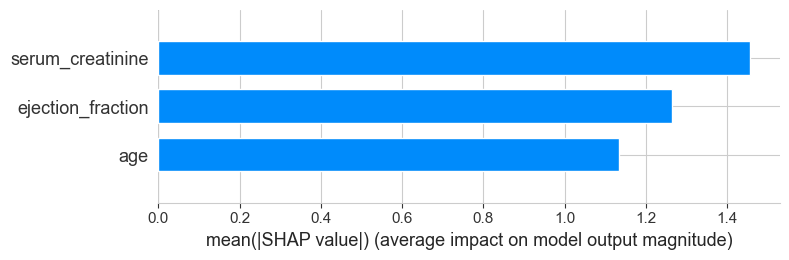


Plotting SHAP Summary Plot (Distribution):


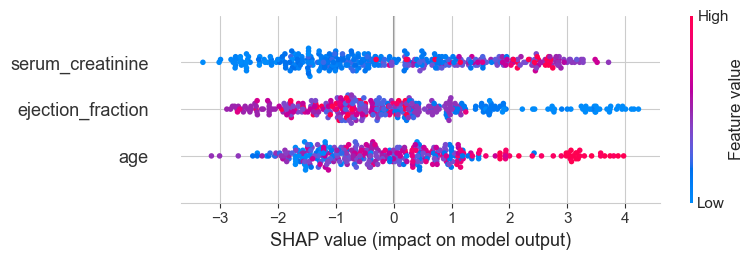

Notebook execution finished.


In [50]:
# %%
best_lgbm_model = best_estimators.get("LightGBM")

if best_lgbm_model:
    print("\nCalculating SHAP values for LightGBM model...")
    X_shap = X_train_smote

    try:
        explainer = shap.TreeExplainer(best_lgbm_model)
        shap_values = explainer.shap_values(X_shap)

        if isinstance(shap_values, list) and len(shap_values) > 1:
            shap_values_plot = shap_values[1]
        else:
            shap_values_plot = shap_values

        print("Plotting SHAP Summary Plot (Feature Importance):")
        shap.summary_plot(
            shap_values_plot,
            X_shap,
            feature_names=features_ml,
            plot_type="bar",
        )
        plt.show()

        print("\nPlotting SHAP Summary Plot (Distribution):")
        shap.summary_plot(shap_values_plot, X_shap, feature_names=features_ml)
        plt.show()

    except Exception as e:
        print(f"Error calculating/plotting SHAP values: {e}")

else:
    print("LightGBM model not found in best estimators, skipping SHAP analysis.")

print("Notebook execution finished.")